# EPW Creator

In this notebook I will put together the code to create .epw files from the output of UKCP18. First I will need to collect/calculate all the necessary variables. I will then need to collate these into a file in .epw format. Currently the data is filed by variable, some data files contain a year of data, others a month.

### Things to achieve in this notebook

[ ] Collect variables from UKCP18 for each year

[ ] Intepolate where needed
    - Validate interpolation by recreating observed data where possible

[ ] Calculate remaining varaibles

[ ] Add missing values 

[ ] Collate variables into .epw file

### Import useful packages

In [4]:
from os import listdir
import csv
import pandas as pd
import numpy as np
from math import exp
from math import log
from metpy import calc
import matplotlib.pyplot as plt
import seaborn

## Write code for a single .epw

1) Dry bulb temperature

In [5]:
# Collect dry bulb temperature for the year
path_tas = "C:/Users/beckr/Documents/Virtual Internship/code/netcf/UKCP18/tas/"
filenames = listdir(path_tas)
location = "[287, 319]"
dry_bulb = []
for filename in filenames:
    year = int(filename[35:39])
    if year == 2061:
        df = pd.read_csv(path_tas + filename)
        dry_bulb = np.concatenate((dry_bulb, df[location].to_numpy()))

2) Relative Humidity 

In [6]:
C1 = -5.6745359e+3
C2 = 6.3925247e00
C3 = -9.6778430e-3
C4 = 6.2215701e-7
C5 = 2.0747825e-9
C6 = -9.4840240e-13
C7 = 4.1635019e00
C8 = -5.8002206e+03
C9 = 1.3914993e+00
C10 = -4.8640239e-02
C11 = 4.1764768e-05
C12 = -1.4452093e-08
C13 = 6.5459673E+00

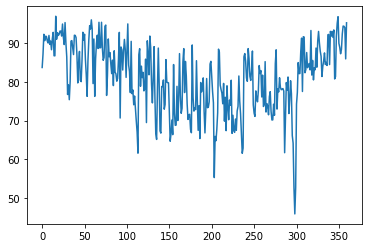

In [7]:
# For each day get specific humidity. Covert to relative humidity with hourly dry bulb. Check against relative humidity value. 
location = "[287, 319]"

path_huss = "C:/Users/beckr/Documents/Virtual Internship/code/netcf/UKCP18/huss/"
filenames_huss = listdir(path_huss)
path_hurs = "C:/Users/beckr/Documents/Virtual Internship/code/netcf/UKCP18/hurs/"
filenames_hurs = listdir(path_hurs)
path_psl = "C:/Users/beckr/Documents/Virtual Internship/code/netcf/UKCP18/psl/"
filenames_psl = listdir(path_psl)

RH = []

for year in range(20):
    filename_hurs = filenames_hurs[year]
    hurs = pd.read_csv(path_hurs + filename_hurs)[location].to_numpy()
    filename_psl = filenames_psl[year]
    psl = pd.read_csv(path_psl + filename_psl)[location].to_numpy()
    year = int(filename_hurs[36:40])
    if year == 2061:
        plt.plot(hurs)
        day = 0
        for hour in range (0, 8640, 24):
            RH_daily = []
            airtemps = dry_bulb[hour:hour+24]
            avg_airtemp = np.mean(airtemps)
            avg_T = avg_airtemp + 273.15
            if  avg_airtemp < 0:
                pws = exp(C1/avg_T + C2 + C3*avg_T + C4*avg_T**2 + C5*avg_T**3 + C6*avg_T**4 + C7*log(avg_T))/1e3
            else:
                pws = exp(C8/avg_T + C9 + C10*avg_T + C11*avg_T**2 + C12*avg_T**3 + C13*log(avg_T))/1e3
            pw = (hurs[day]/100)*pws
            W = 0.621945*pw/(psl[day]-pw)
            huss = W/(1+W)
            for airtemp in airtemps:
                T = airtemp + 273.15
                if  airtemp < 0:
                    pws = exp(C1/T + C2 + C3*T + C4*T**2 + C5*T**3 + C6*T**4 + C7*log(T))/1e3
                else:
                    pws = exp(C8/T + C9 + C10*T + C11*T**2 + C12*T**3 + C13*log(T))/1e3
                rh = min([(pw/pws)*100, 100])
                RH.append(rh)   
            day = day + 1

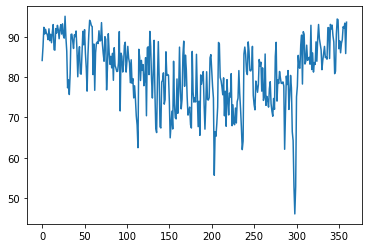

In [8]:
x = []
for hour in range (0, 8640, 24):
    x_val = np.mean(RH[hour:hour+24])
    x.append(x_val)
plt.plot(x)
plt.show()

C:\Users\beckr\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

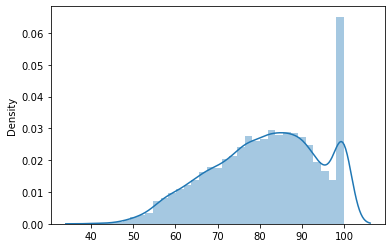

In [9]:
seaborn.distplot(RH)

**Notes:** Not working yet - outputs values greater than 100. Capped at 100.

3) Dew point

In [35]:
dew_point = np.zeros(len(dry_bulb))
for i in range(len(dry_bulb)):
    T = dry_bulb[i]
    rh = RH[i]
    dew_point[i] = 243.04*(log(rh/100)+((17.625*T)/(243.04+T)))/(17.625-log(rh/100)-((17.625*T)/(243.04+T)))

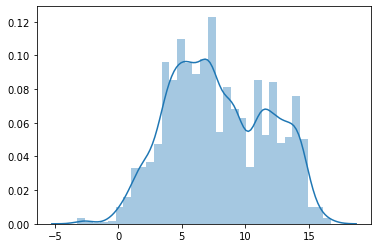

In [36]:
seaborn.distplot(dew_point)

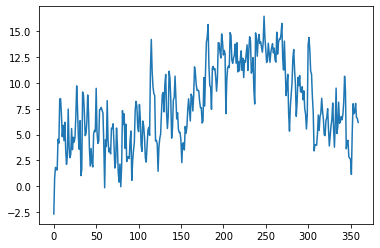

In [37]:
x = []
for hour in range (0, 8640, 24):
    x_val = np.mean(dew_point[hour:hour+24])
    x.append(x_val)
plt.plot(x)
plt.show()